In [17]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import graphviz as gr
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [11]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [12]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

# Q1 Covariates

# (1) Experiments with no covariates in the DGP

𝑦𝑖=𝜏∗𝑇𝑖+𝑒𝑖

Example: If we want to test the relationship between sales volumn and different color of a good such as the cup. We need to control the other varibles. The price, material, size, shape and so on should be the same. Then we can know which color is the best selling.

t: color y:popularity

In [ ]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("Xi","Y",style="dashed")
g

In [8]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|███████████████████████████████████████████████████████████████████████████████| 495/495 [00:00<00:00, 512.33it/s]


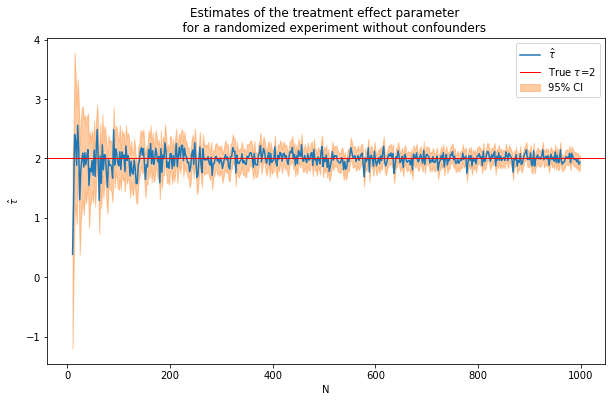

In [9]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

In [ ]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [ ]:
tauhat,se_tauhat

In [ ]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

# Run R Monte Carlo iterations and compute bias, RMSE and size

In [ ]:
estDict = {}
R = 2000
for N in [10,50,100,500,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

In [ ]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

# (2) Experiments with covariates in the DGP

𝑦𝑖=𝜏∗𝑇𝑖+𝛽'∗𝑥𝑖+𝑒𝑖

Now there are other variables may effect the sales volume of the cups,such as the price, material, size, shape and so on.

In [ ]:
g = Digraph()
g.edge("T", "Y")
g.edge("X","Y")
g

In [ ]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

In [ ]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

In [ ]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [ ]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x0,tauhats_x0,sehats_x0,lb_x0,ub_x0) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

In [ ]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x,tauhats_x,label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x,tauhats_x0,label = '$\hat{\\tau}$',color = 'green')
plt.legend()

In [ ]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x[400:],tauhats_x[400:],label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x[400:],tauhats_x0[400:],label = '$\hat{\\tau}$',color = 'green')
plt.legend()

In [ ]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(1000,50000,10000) # loop over N values
(nvalues_x2,tauhats_x2,sehats_x2,lb_x2,ub_x2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

In [ ]:
fn_plot_with_ci(nvalues_x2,tauhats_x2,tau,lb_x2,ub_x2,caption)

# Run R Monte Carlo iterations and compute bias, RMSE and size

In [ ]:
estDict = {}
R = 2000
for N in [10,50,100,500,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

In [ ]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

# Q2

# (1) Fail to control for the confounder

Example: If the seller sells a tea spoon and a cup as a combo, the tea spoon will influence the sales volume of the cup. If the tea spoon very ugly or very poor quality, it will decrease the sales volume of the cup. The tea spoon in the confounder in this case.

𝑦𝑖=𝜏∗𝑇𝑖+𝑒𝑖

In [ ]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("Xi","Y",style="dashed")
g

In [ ]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

In [ ]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

In [ ]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat

In [ ]:
tauhat,se_tauhat

In [ ]:
const = np.ones([N,1])

In [ ]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

# Run R Monte Carlo iterations and compute bias, RMSE and size( For N=100 and N=1000)

In [ ]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])

# (2) Control the confounder

𝑦𝑖=𝜏∗𝑇𝑖+𝑥𝑖+𝑒𝑖

In [ ]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("right Xi","Y")
g.edge("conf","Y")
g.edge("conf","Ti")
g

In [ ]:
tau = 2
corr = .5
conf = True
p = 100
p0 = 0  # number of covariates used in the DGP
Nrange = range(10, 1000, 2)  # loop over N values
(nvalues3, tauhats3, sehats3, lb3, ub3) = fn_run_experiments(tau, Nrange, p, p0, corr, conf)

In [ ]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

In [ ]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = FalseN = 100
Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf= True)
Yt = Yexp[np.where(T == 1)[0], :]
Yc = Yexp[np.where(T == 0)[0], :]
tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
lb = lb + [tauhat - 1.96 * se_tauhat]
ub = ub + [tauhat + 1.96 * se_tauhat]
# Tau hat & S.d Tauhat
tauhat, se_tauhat)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

# Run R Monte Carlo iterations and compute bias, RMSE and size ( For N=100 and N=1000)

In [ ]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

In [ ]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

# Q3
Example: Now consider the gender of the customers. If there are more women to buy the cups in the data collection. The shop may consider 
the color of women preference such as pink. However, there is not necessary connection between the fender of customers and the sales volumn of the cups with different colors. Sometimes women buy cups for their sons or husband. 

# control for the variable in between the path from cause to effect

𝑦𝑖=𝜏∗𝑇𝑖+𝑒𝑖

In [ ]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g

In [ ]:
tau = 3
corr = .5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

In [ ]:
caption = """Estimates of the treatment effect parameter
    for a randomized experiment with Selection Bias"""
fn_plot_with_ci(nvalues4,tauhats4,tau,lb4,ub4,caption)

In [ ]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [ ]:
tauhat, se_tauhat

In [ ]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

In [ ]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

# do not control for the variable in between the path from cause to effect

𝑦𝑖=𝜏∗𝑇𝑖+𝛽∗𝑋𝑖+𝑒𝑖

In [ ]:
tau = 3
beta = 2
corr = .5
conf = True
p = 100
p0 = 0  # number of covariates used in the DGP
Nrange = range(10, 1000, 2)  # loop over N values
(nvalues3, tauhats3, sehats3, lb3, ub3) = fn_run_experiments(tau, Nrange, p, p0, corr, conf)

In [ ]:
N = 100
Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf=True)
Yt = Yexp[np.where(T == 1)[0], :]
Yc = Yexp[np.where(T == 0)[0], :]
tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
lb = lb + [tauhat - 1.96 * se_tauhat]
ub = ub + [tauhat + 1.96 * se_tauhat]

In [ ]:
tauhat, se_tauhat

In [ ]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])

In [ ]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')